In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import BinaryAccuracy


In [2]:
data = pd.read_csv('Washington_State_HDMA-2016.csv') # description: https://cfpb.github.io/hmda-platform/#data-browser-api

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data

,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,state_name,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
0,121.690002,NaN,8381.0,23.790001,2175.0,2660.0,227,73300.0,116.0,Washington,...,Female,NaN,NaN,NaN,NaN,"Information not provided by applicant in mail,...",Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Loan originated
1,83.370003,NaN,4915.0,23.990000,1268.0,1777.0,240,57900.0,42.0,Washington,...,Male,NaN,NaN,NaN,NaN,White,Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated
2,91.129997,NaN,5075.0,11.820000,1136.0,1838.0,241,73300.0,117.0,Washington,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated
3,146.169998,NaN,5032.0,8.590000,1525.0,1820.0,351,73300.0,315.0,Washington,...,Male,NaN,NaN,NaN,NaN,"Information not provided by applicant in mail,...","Information not provided by applicant in mail,...",National Credit Union Administration,NCUA,Loan originated
4,162.470001,NaN,5183.0,10.500000,1705.0,2104.0,417,78100.0,114.0,Washington,...,Female,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Federal Deposit Insurance Corporation,FDIC,Loan originated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466561,NaN,NaN,NaN,NaN,NaN,NaN,178,NaN,97.0,Washington,...,Female,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Preapproval request denied by financial instit...
466562,NaN,NaN,NaN,NaN,NaN,NaN,110,NaN,30.0,Washington,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Preapproval request denied by financial instit...
466563,NaN,NaN,NaN,NaN,NaN,NaN,420,NaN,71.0,Washington,...,Female,NaN,NaN,NaN,NaN,"Information not provided by applicant in mail,...","Information not provided by applicant in mail,...",Department of Housing and Urban Development,HUD,Preapproval request approved but not accepted
466564,88.690002,NaN,4725.0,45.880001,1188.0,1686.0,255,72300.0,77.0,Washington,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Preapproval request approved but not accepted


### target variables
 - action_taken_name
 - denial_reason_name_1
 - denial_reason_name_2
 - denial_reason_name_3


### variables we maybe need to leave out:
 - sequence_number
 - respondent_id
 - purchaser_type_name # will be fix for excelsis so leave this out.

In [4]:
data.columns

Index(['tract_to_msamd_income', 'rate_spread', 'population',
       'minority_population', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units', 'loan_amount_000s',
       'hud_median_family_income', 'applicant_income_000s', 'state_name',
       'state_abbr', 'sequence_number', 'respondent_id', 'purchaser_type_name',
       'property_type_name', 'preapproval_name', 'owner_occupancy_name',
       'msamd_name', 'loan_type_name', 'loan_purpose_name', 'lien_status_name',
       'hoepa_status_name', 'edit_status_name', 'denial_reason_name_3',
       'denial_reason_name_2', 'denial_reason_name_1', 'county_name',
       'co_applicant_sex_name', 'co_applicant_race_name_5',
       'co_applicant_race_name_4', 'co_applicant_race_name_3',
       'co_applicant_race_name_2', 'co_applicant_race_name_1',
       'co_applicant_ethnicity_name', 'census_tract_number', 'as_of_year',
       'application_date_indicator', 'applicant_sex_name',
       'applicant_race_name_5', 'applicant_rac

In [5]:
data[~data['denial_reason_name_1'].isnull()]['denial_reason_name_1'].value_counts()

Debt-to-income ratio                              8648
Credit history                                    7671
Collateral                                        5748
Credit application incomplete                     5433
Other                                             4058
Unverifiable information                          1353
Insufficient cash (downpayment, closing costs)    1036
Employment history                                 535
Mortgage insurance denied                           17
Name: denial_reason_name_1, dtype: int64

In [6]:
data['action_taken_name'].value_counts()

Loan originated                                        263712
Application denied by financial institution             64177
Application withdrawn by applicant                      60358
Loan purchased by the institution                       48356
File closed for incompleteness                          18176
Application approved but not accepted                   11735
Preapproval request denied by financial institution        35
Preapproval request approved but not accepted              17
Name: action_taken_name, dtype: int64

In [7]:
data['preapproval_name'].value_counts()

Not applicable                   397521
Preapproval was not requested     57700
Preapproval was requested         11345
Name: preapproval_name, dtype: int64

In [8]:
data[data['preapproval_name'] == 'Preapproval was requested']['action_taken_name'].value_counts()

Loan originated                                        8962
Application withdrawn by applicant                     1014
Application approved but not accepted                   626
Application denied by financial institution             591
File closed for incompleteness                          100
Preapproval request denied by financial institution      35
Preapproval request approved but not accepted            17
Name: action_taken_name, dtype: int64

### Remove the following data points
Where action_taken_name is one of the following value:
 - Application withdrawn by applicant
 - Application approved but not accepted
 - Preapproval request denied by financial institution
 - Preapproval request approved but not accepted

In [9]:
data['msamd_name'].value_counts()

Seattle, Bellevue, Everett - WA            196473
Tacoma, Lakewood - WA                       61552
Portland, Vancouver, Hillsboro - OR, WA     38729
Spokane, Spokane Valley - WA                32050
Bremerton, Silverdale - WA                  18146
Olympia, Tumwater - WA                      17739
Kennewick, Richland - WA                    15949
Bellingham - WA                             12629
Yakima - WA                                  9731
Mount Vernon, Anacortes - WA                 7930
Longview - WA                                6940
Wenatchee - WA                               6242
Walla Walla - WA                             3099
Lewiston - ID, WA                            1083
Name: msamd_name, dtype: int64

In [10]:
data['purchaser_type_name'].value_counts()

Loan was not originated or was not sold in calendar year covered by register    220297
Fannie Mae (FNMA)                                                                75990
Ginnie Mae (GNMA)                                                                60831
Freddie Mac (FHLMC)                                                              51808
Life insurance company, credit union, mortgage bank, or finance company          21510
Commercial bank, savings bank or savings association                             18283
Other type of purchaser                                                          11921
Affiliate institution                                                             3994
Private securitization                                                            1914
Farmer Mac (FAMC)                                                                   18
Name: purchaser_type_name, dtype: int64

In [11]:
data['property_type_name'].value_counts()

One-to-four family dwelling (other than manufactured housing)    450406
Manufactured housing                                              14504
Multifamily dwelling                                               1656
Name: property_type_name, dtype: int64

In [12]:
print(data['loan_type_name'].value_counts())
print(data['loan_purpose_name'].value_counts())
print(data['lien_status_name'].value_counts())
print(data['hoepa_status_name'].value_counts())
print(data['edit_status_name'].value_counts())

Conventional          332433
FHA-insured            66754
VA-guaranteed          62915
FSA/RHS-guaranteed      4464
Name: loan_type_name, dtype: int64
Refinancing         250046
Home purchase       192684
Home improvement     23836
Name: loan_purpose_name, dtype: int64
Secured by a first lien          403525
Not applicable                    48356
Secured by a subordinate lien      9298
Not secured by a lien              5387
Name: lien_status_name, dtype: int64
Not a HOEPA loan    466553
HOEPA loan              13
Name: hoepa_status_name, dtype: int64
Quality edit failure only    74505
Name: edit_status_name, dtype: int64


In [13]:
data['census_tract_number'].value_counts()

2.00       2698
8.00       2059
7.00       1914
101.00     1849
106.00     1841
           ... 
729.07        2
105.10        2
9204.00       1
808.00        1
9901.00       1
Name: census_tract_number, Length: 1116, dtype: int64

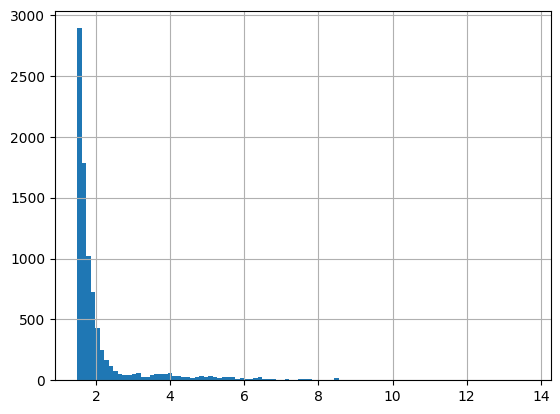

In [25]:
data['rate_spread'].hist(bins=100)
plt.show()

# Data preparation

In [19]:
# remove the unhelpful rows
# - Application withdrawn by applicant
# - Application approved but not accepted
# - Preapproval request denied by financial institution
# - Preapproval request approved but not accepted

data_clean = data.drop(data[(data.action_taken_name == "Application withdrawn by applicant") | \
                            (data.action_taken_name == "Application approved but not accepted") | \
                            (data.action_taken_name == "Preapproval request denied by financial institution") | \
                            (data.action_taken_name == "Preapproval request approved but not accepted")].index)

# turn our target into binary
data_clean['loan_approved'] = data_clean['action_taken_name'] == "Loan originated"

# remove unnecessary columns
data_clean = data_clean.drop(columns=["action_taken_name", \
                         "sequence_number", \
                         "respondent_id", \
                         "purchaser_type_name", \
                         "denial_reason_name_1", \
                         "denial_reason_name_2", \
                         "denial_reason_name_3"])

# replace nan with 0 in rate_spread
data_clean.fillna(0, inplace=True)


# turn categorial into dummies
categorial_names = list(set(data_clean.columns) - set(data_clean._get_numeric_data().columns))
data_clean = pd.get_dummies(data=data_clean, columns=categorial_names, drop_first=True)

data_clean

,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,census_tract_number,...,loan_purpose_name_Home purchase,loan_purpose_name_Refinancing,applicant_race_name_5_Asian,applicant_race_name_5_Black or African American,applicant_race_name_5_White,preapproval_name_Preapproval was not requested,preapproval_name_Preapproval was requested,"applicant_sex_name_Information not provided by applicant in mail, Internet, or telephone application",applicant_sex_name_Male,applicant_sex_name_Not applicable
0,121.690002,0.0,8381.0,23.790001,2175.0,2660.0,227,73300.0,116.0,413.27,...,0,1,0,0,0,0,0,0,0,0
1,83.370003,0.0,4915.0,23.990000,1268.0,1777.0,240,57900.0,42.0,9208.01,...,1,0,0,0,0,0,0,0,1,0
2,91.129997,0.0,5075.0,11.820000,1136.0,1838.0,241,73300.0,117.0,414.00,...,0,1,0,0,0,0,0,0,1,0
3,146.169998,0.0,5032.0,8.590000,1525.0,1820.0,351,73300.0,315.0,405.10,...,0,1,0,0,0,0,0,0,1,0
4,162.470001,0.0,5183.0,10.500000,1705.0,2104.0,417,78100.0,114.0,907.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466553,91.070000,0.0,6792.0,16.889999,1763.0,2280.0,225,69900.0,54.0,103.01,...,1,0,0,0,0,0,0,0,1,0
466554,128.800003,0.0,4966.0,11.500000,1561.0,1870.0,100,69900.0,21.0,8.05,...,1,0,0,0,0,0,0,0,0,0
466555,99.669998,0.0,4950.0,29.639999,1594.0,1742.0,196,90300.0,0.0,219.05,...,0,1,0,0,0,0,0,0,0,1
466556,88.889999,0.0,3233.0,16.610001,1055.0,1278.0,169,73600.0,0.0,125.10,...,1,0,0,0,0,0,0,0,0,1


In [20]:
X = data_clean.drop('loan_approved', axis=1).values
y = data_clean['loan_approved'].values
print(X.shape)
print(y.shape)


(394421, 146)
(394421,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31)

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
model.score(X_test, y_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7775515044450442

In [44]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1, activation='sigmoid', input_dim=100))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
history = model.fit(X_test, y_test, epochs=10, validation_data=(X_test, y_test))

Epoch 1/3
3821/3821 [==============================] - 10s 3ms/step - loss: 36.9344 - binary_accuracy: 0.6019 - val_loss: 7.2782 - val_binary_accuracy: 0.5504
Epoch 2/3
3821/3821 [==============================] - 9s 2ms/step - loss: 17.7051 - binary_accuracy: 0.6375 - val_loss: 22.5275 - val_binary_accuracy: 0.7173
Epoch 3/3
3821/3821 [==============================] - 9s 2ms/step - loss: 13.2104 - binary_accuracy: 0.6634 - val_loss: 23.9030 - val_binary_accuracy: 0.7284


{'verbose': 1, 'epochs': 3, 'steps': 3821}


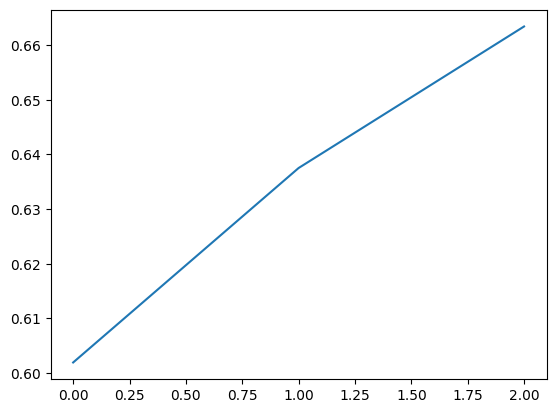

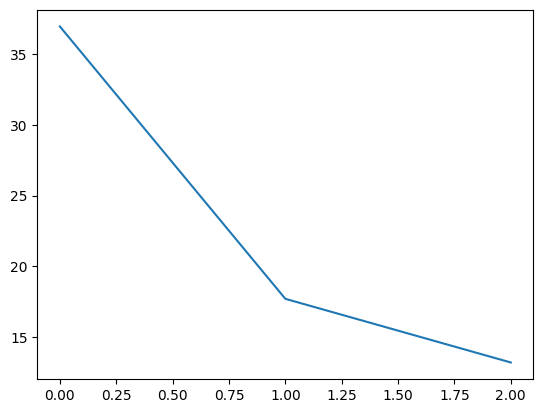

In [45]:
print(history.params)
plt.plot(history.history['binary_accuracy'])
plt.show()
plt.plot(history.history['loss'])
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=03c1f381-4bef-44c8-9167-00386ebceba9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>